In [179]:
import pandas as pd
import numpy as np
import operator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Loads in the different .feather datasets


In [180]:
anp_df = pd.read_feather('data/anp.feather')
image_d_df = pd.read_feather('data/image_data.feather')
image_m_df = pd.read_feather('data/image_metrics.feather')
face_df = pd.read_feather('data/face.feather')
object_df = pd.read_feather('data/object_labels.feather')
survey_df = pd.read_feather('data/survey.feather')

In [181]:
image_d_df.to_csv('image_d_df.csv')
image_m_df.to_csv('image_m_df.csv')


In [182]:
image_d_df = pd.read_feather('data/image_data.feather')

# Adding together image data, anp, object label and face.

The next step is to create one dataframe, grouped per user, containing the aggregate data that was pulled from the users their instagram accounts. 


## anp_df

#### method:

1. the anp label is dropped because it does not make sense to aggregate this. 
2. the dataframe is then split into a sentiment dataframe and an emotion dataframe for seperate processing.

In [183]:
# drop anp_label

anp_df = anp_df.drop(['anp_label'], axis=1)

In [184]:
# make sentiment df

anp_sent = anp_df.drop(['emotion_score', 'emotion_label'], axis = 1)
anp_sent = pd.DataFrame(anp_sent.groupby(by='image_id', as_index=False)['anp_sentiment'].mean())
anp_sent = anp_sent.set_index('image_id')

In [185]:
# split for emotion

anp_emo = anp_df.drop(['anp_sentiment'], axis = 1)
len(anp_emo['image_id'].unique())

41292

In [186]:
# the emotion with the highest score is taken for each user

ax = anp_emo.groupby(['image_id'])['emotion_score'].transform(max) == anp_emo['emotion_score']
anp_emo = anp_emo[ax]

In [187]:
# duplicates are removed to get only unique images

anp_emo = anp_emo.drop_duplicates()
anp_emo = anp_emo.set_index('image_id')


In [188]:
# the emotion and sentiment dataframes are merged again.

anp_final = anp_sent.join(anp_emo)

## Image_d_df

#### method:
1. Thing that can not be aggregated such as image_link, etc, are dropped from the dataframe. 
2. Timestamp is changed so that only the hour from 00 - 23 is included.

In [189]:
# drop unnecesarry data

image_d_df = image_d_df.drop(['image_link','image_url', 'user_full_name', 'user_name'\
                              , 'user_website','user_profile_pic', 'user_bio', 'image_posted_time_unix'], axis=1)

In [190]:
# change timestamp to be 24 hours

import re

def changeTime(time):
    time = time.split()[1]
    time = time.split(':')[0]
    time = time.lstrip('0')
    time = ''.join([i for i in time if re.match('[0-9]', i) is not None])
    try: 
        return int(time)
    except:
        return 0

image_d_df['posting_time'] = image_d_df['image_posted_time'].apply(lambda x: changeTime(x))

In [191]:
# set indesx to image id and drop image_posted_time

image_d_df = image_d_df.set_index('image_id')
image_d_df = image_d_df.drop('image_posted_time', axis=1)

## Image_m_df

#### method: 
1. drop things that we do not need

In [192]:
image_m_df = image_m_df.drop(['comment_count_time_created', 'like_count_time_created'], axis=1)


In [193]:
image_m_df = image_m_df.set_index('image_id')
image_m_df.head()

,comment_count,like_count
image_id,,
1337283311810249709_3041716852,0.0,15.0
1337283311810249709_3041716852,0.0,15.0
1337834353379743556_3041716852,0.0,23.0
1337834353379743556_3041716852,0.0,23.0
1516356155708878303_3041716852,5.0,19.0




## object_df

#### method:
1. Only take the object with highest confidence level for each picture. 


In [194]:
# take object with max confidence

group = object_df.groupby(['image_id', 'data_amz_label'])['data_amz_label_confidence'].transform(max) == object_df['data_amz_label_confidence']
object_df = object_df[group]

## face_df: emotion

#### method:

1. first a split is made for face emotion
2. images are grouped by image_id and face_id, for each image we check how many faces have a certain emotion. The highest number of face emotions is picked as the image emotion.
3. If we have an equal number (let's say 1 joy face and 1 sad face, the emotion with the highest confidence level is selected.) 


In [195]:
# first, split for face emotion

face_emo = face_df[['image_id', 'face_id', 'face_emo', 'emo_confidence']]
ab = face_emo.groupby(['image_id', 'face_id'])['emo_confidence'].transform(max) == face_emo['emo_confidence']
face_emo = face_emo[ab]


In [196]:

# get unique image_id's
UniqueNames = face_emo.image_id.unique()

def changeDataFrame(df):
    
    new_list = []
    
    for _id in UniqueNames:
        
        # check whether one emotion is found more often than others
        
        df_temp = face_emo.loc[face_emo['image_id'] == _id]
        counts = df_temp['face_emo'].value_counts().to_dict()
        maximum = sorted(counts.items(), key=operator.itemgetter(1))

        # if there is an equal number of emotions look at confidence.
        
        if len(maximum) > 1:
            if maximum[0][1] == maximum[1][1]:

                group = df_temp.groupby(['image_id'])['emo_confidence'].transform(max) == df_temp['emo_confidence']
                new_slice = df_temp[group]
                new_list.append([new_slice['image_id'].values[0], new_slice['face_emo'].values[0]])  
                
            else: 
                new_list.append([df_temp['image_id'].values[0], maximum[0][0]])

        # else select the emotion that is present on most faces.
        
        else: 
            new_list.append([df_temp['image_id'].values[0], maximum[0][0]])
            
    output_df = pd.DataFrame(new_list, columns=['image_id','face_emo'])
    
    return output_df
    

new_emo = changeDataFrame(face_emo)

## face_df: finding the number of faces

#### method:
1. aggregate number of faces per picture


In [197]:
# take image_id, face_id and emo_confidence

face_no_df = face_df[['image_id', 'face_id', 'emo_confidence']]
group = face_no_df.groupby(['image_id', 'face_id'])['emo_confidence'].transform(max) == face_no_df['emo_confidence']
face_no_df = face_no_df[group].drop('emo_confidence', axis=1)

In [198]:
# aggregate for number of faces 
face_count_df = pd.DataFrame(face_no_df['image_id'].value_counts())
face_count_df['no_of_faces'] = face_count_df['image_id']
face_count_df = face_count_df.drop('image_id', axis=1)


## face_df: find average age per picture

1. select face age low and high
2. take the mean value for each face
3. take the mean of those values for each picture

In [199]:
face_df_age = face_df[['image_id', 'face_age_range_low', 'face_age_range_high']]

In [200]:
# taking mean per face
face_df_age['average_age'] = (face_df_age['face_age_range_low'] + face_df_age['face_age_range_high'])/2
face_df_age

# taking mean per picture
average_age_df = pd.DataFrame(face_df_age.groupby('image_id')['average_age'].mean())

/Users/tom/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [201]:
# object_df.to_csv('object.csv')
# face_df.to_csv('face.csv')

In [202]:
# survey_df.to_csv('survey.csv')

In [218]:
image_d_df.head()

,image_height,image_width,image_filter,data_memorability,user_id,user_followed_by,user_follows,user_posted_photos,posting_time
image_id,,,,,,,,,
1316962883971761394_3468175004,640.0,640.0,Lo-fi,0.800521,3468175004,7.0,0.0,1.0,22
552382455733335946_263042348,612.0,612.0,Normal,0.875568,263042348,316.0,347.0,73.0,0
594552614686078174_263042348,640.0,640.0,Vesper,0.672679,263042348,316.0,347.0,73.0,4
553884883234370621_263042348,640.0,640.0,Amaro,0.843525,263042348,316.0,347.0,73.0,2
725551583154452417_263042348,640.0,640.0,Amaro,0.859796,263042348,316.0,347.0,73.0,22


# Merge different dataframes

1. join different dataframes by image_id
2. aggregate for user_id

In [204]:
# merge different dataframes
df1 = anp_final.join(image_d_df)
df2 = df1.join(face_count_df)
df3 = df2.join(average_age_df)
df4 = df3.join(image_m_df)



'''
' TODO
' Also join object dataframe and new_emo dataframe
'''

"\n' TODO\n' Also join object dataframe and new_emo dataframe\n"

In [219]:
df4.head()

,anp_sentiment,emotion_score,emotion_label,image_height,image_width,image_filter,data_memorability,user_id,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age,comment_count,like_count
1000004599066965477_545497348,0.0486,0.2296,amazement,640.0,640.0,Normal,0.873700,545497348,1345.0,498.0,505.0,14.0,NaN,NaN,4.0,43.0
1000059425592054064_703978203,-0.1062,0.3468,amazement,640.0,640.0,Normal,0.807139,703978203,687.0,376.0,2277.0,16.0,NaN,NaN,1.0,8.0
1000065308809420330_46329534,-0.0050,0.2369,amazement,640.0,640.0,Lark,0.776858,46329534,322.0,559.0,503.0,16.0,NaN,NaN,0.0,8.0
1000080765059521113_31736205,0.2522,0.3122,joy,640.0,640.0,Lark,0.856762,31736205,732.0,201.0,1052.0,17.0,NaN,NaN,1.0,13.0
1000097452173278518_206726006,-0.0246,0.5639,joy,640.0,640.0,Reyes,0.873222,206726006,1261.0,147.0,392.0,18.0,NaN,NaN,2.0,27.0


In [220]:
quant_df = df4.drop(['emotion_label', 'emotion_score', 'image_filter'], axis=1)
quant_df.head()

,anp_sentiment,image_height,image_width,data_memorability,user_id,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age,comment_count,like_count
1000004599066965477_545497348,0.0486,640.0,640.0,0.873700,545497348,1345.0,498.0,505.0,14.0,NaN,NaN,4.0,43.0
1000059425592054064_703978203,-0.1062,640.0,640.0,0.807139,703978203,687.0,376.0,2277.0,16.0,NaN,NaN,1.0,8.0
1000065308809420330_46329534,-0.0050,640.0,640.0,0.776858,46329534,322.0,559.0,503.0,16.0,NaN,NaN,0.0,8.0
1000080765059521113_31736205,0.2522,640.0,640.0,0.856762,31736205,732.0,201.0,1052.0,17.0,NaN,NaN,1.0,13.0
1000097452173278518_206726006,-0.0246,640.0,640.0,0.873222,206726006,1261.0,147.0,392.0,18.0,NaN,NaN,2.0,27.0


In [221]:
quant_df = quant_df.groupby(by='user_id').mean()
# quant_df.to_csv('analysisfile.csv')
quant_df.head()

,anp_sentiment,image_height,image_width,data_memorability,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age,comment_count,like_count
user_id,,,,,,,,,,,,
1097967773,0.301873,636.831615,632.302405,0.843469,53.0,154.0,282.0,10.883162,1.232558,5.686047,0.708333,5.802083
11520833,0.069663,617.157051,617.166667,0.819178,201.0,299.0,312.0,9.669872,1.701754,26.738697,0.356557,5.540984
1223036636,-0.003506,640.000000,640.000000,0.869481,169.0,159.0,48.0,14.708333,1.461538,40.282051,1.978723,11.340426
1224423305,-0.062127,432.365854,593.170732,0.790601,1.0,18.0,41.0,14.243902,1.000000,54.000000,0.000000,0.052632
1249457735,0.054133,645.333333,640.000000,0.804556,66.0,93.0,30.0,13.433333,1.500000,10.835417,0.241379,5.689655


In [208]:
# quant_df = pd.read_csv('analysisfile.csv')
# face_df = pd.read_csv('face.csv')
# survey_df = pd.read_csv('survey.csv')

In [209]:
# quant_df.to_csv('analysis.csv')

## Extra: try to get smile percentage per picture

In [222]:
# Takes all the face smiles where the confidence level is more than 80 percent
face_smile_df = face_df.loc[face_df['face_smile_confidence'] > 80]

# make dataframe split to include smile
face_smile_df = face_smile_df[['image_id', 'face_smile', 'face_id']]

# drop duplicate values
face_smile_df = face_smile_df.drop_duplicates()
face_smile_df = face_smile_df.drop('face_id', axis=1)

group = face_smile_df.groupby(['image_id', 'face_smile'])['face_smile'].count()
group = pd.DataFrame(group / group.groupby(level=0).sum())
# face_smile_df[group]

group.head()
# face_smile_df = group.loc[group['face_smile'] == True]
# face_smile_df


# face_smile_df = face_smile_df.groupby(by='image_id')['face_smile'].count()
# face_smile_df.head

face_smile
image_id                      face_smile            
1000126179441391393_30837828  True               1.0
1000135251972767429_31447990  True               1.0
1000159024449036821_265063047 True               1.0
1000236251867593988_22180590  False              0.5
                              True               0.5

## Merge survey dataframe and analysis dataframe

In [211]:
survey_df = pd.read_feather('data/survey.feather')

In [212]:
survey_df['insta_user_id'] = survey_df['insta_user_id'].apply(lambda x: str(int(x)))

In [213]:
survey_df = survey_df.set_index('insta_user_id')


In [223]:
survey_df.head()

,id,gender,born,education,employed,income,A_2,N_1,P_1,E_1,...,P,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,private_account
insta_user_id,,,,,,,,,,,,,,,,,,,,,
619868570,920bf027f7d13dbdc7b66b3d3324903c,Male,1975,College graduate,Employed for wages,"$30,000 to $39,999",4,5,5,3,...,5,3.0,6.0,6.0,4.0,5,5.0,5,465.0,public
187920333,b433b2bfe49e28d0b7c45925b53084e0,Male,1978,College graduate,Employed for wages,"$20,000 to $29,999",8,0,9,7,...,9,7.0,9.0,8.0,7.0,9,0.0,9,6.0,public
513324264,4becd8768d42ffa6ef0a17d827f230a2,Male,1980,High school graduate,Self-employed,"$40,000 to $49,999",7,7,6,9,...,6,9.0,6.0,6.0,8.0,6,7.0,6,NaN,private
3437021077,01d90eeb34866d03c52925738da7865f,Male,1959,College graduate,Employed for wages,"$10,000 to $19,999",6,4,1,5,...,1,5.0,3.0,3.0,3.0,1,4.0,1,NaN,private
33420910,f4f54676f75f47c17dc434cf68845328,Female,1990,High school graduate,Employed for wages,"$80,000 to $89,999",7,3,8,7,...,8,7.0,8.0,8.0,7.0,8,3.0,8,767.0,public


## Regression

In [224]:
regr_df = quant_df.join(survey_df)

In [225]:

regr_df = regr_df.drop(['A_2', 'N_1', 'P_1', 'E_1', 'A_1',
       'H_1', 'M_1', 'R_1', 'M_2', 'E_2', 'LON', 'H_2', 'P_2', 'N_2', 'A_3',
       'N_3', 'E_3', 'H_3', 'R_2', 'M_3', 'R_3', 'P_3', 'HAP','network_id', 'P', 'E', 'R', 'M', 'A', 'start_q', 'end_q', 'private_account'], axis=1)



### Analyzing correlations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a428118d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a44f32358>]], dtype=object)

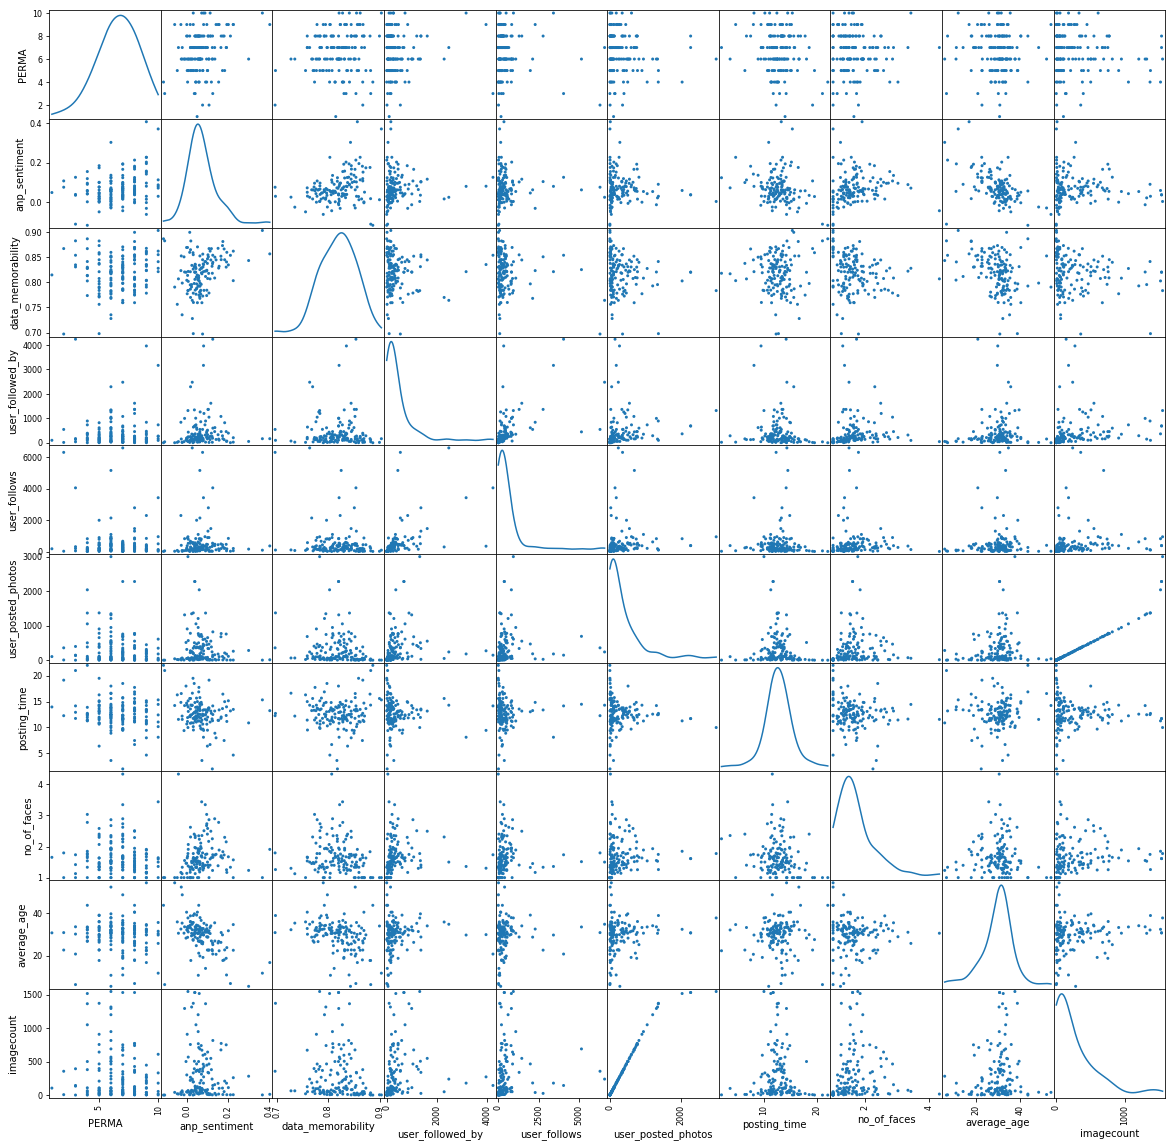

In [283]:
from pandas.plotting import scatter_matrix
%matplotlib inline

scatter_matrix(regr_df[['PERMA','anp_sentiment', 'data_memorability',
       'user_followed_by', 'user_follows', 'user_posted_photos',
       'posting_time', 'no_of_faces', 'average_age','imagecount']], alpha=1.0, figsize=(20, 20), diagonal='kde')


#### Correlation Matrix

In [284]:
# Plot Correlation Matrix using Matplotlib
%pylab inline
plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap='Purples', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Correlations Heat Map', fontsize=15, fontweight='bold')
plt.show()

Populating the interactive namespace from numpy and matplotlib


NameError: name 'corr' is not defined

### Prepare train and test set

In [227]:
new_df = regr_df

new_df.dropna(how='any', inplace=True)

In [235]:
X = new_df[['user_posted_photos', 'user_follows', 'user_followed_by', 'no_of_faces', 'imagecount']].copy()
X['x1'] = X['user_posted_photos'] * X['user_follows']
X['x2'] = X['user_followed_by'] * X['user_followed_by']
X['x3'] = 1 / X['imagecount']

y = new_df['PERMA'].copy()

### Logistic Regression

In [236]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lm = LogisticRegression()

#predicted = cross_val_predict(lr, X_train, y_test, cv=10)

predicted = cross_val_predict(LogisticRegression(), X, y, cv=15)

accuracy = metrics.accuracy_score(y, predicted)

print('Accuracy: ', accuracy)

# Show metrics
#print('Coefficients: \n', lm.coef_)
# The mean squared error
# print("Mean squared error: %.2f"
#       % mean_squared_error(y, y_predict))
# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % r2_score(y, y_predict))

Accuracy:  0.216783216783


/Users/tom/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=15.
  % (min_labels, self.n_folds)), Warning)


## Results from regression

#### 1. PERMA ~ anp_sentiment

Correlation: 0.21477

Coefficients: 
 [[ 4.68761213]]
Mean squared error: 3.59
Variance score: 0.03

#### 2. PERMA ~ posting_time

correlation: -0.205047

Coefficients: 
 [[-0.12492383]]
Mean squared error: 2.93
Variance score: -0.08

#### 3. PERMA ~ data_memorability

correlation: 0.195383

Coefficients: 
 [[ 9.01465037]]
Mean squared error: 1.98
Variance score: -0.04

#### 4. PERMA ~ imagecount	

correlation: -0.112792

Coefficients: 
 [[-0.00031376]]
Mean squared error: 3.32
Variance score: 0.04
